In [52]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
%matplotlib inline

# 1. 读取数据

In [2]:
def load_ICU_data(data_path, label_path):
    if(not data_path.endswith(".csv")):
        print("数据需要csv格式的文件！")
        return None
    if(not label_path.endswith(".csv")):
        print("标签需要csv格式的文件！")
        return None
    data_df = pd.read_csv(data_path)
    label_df = pd.read_csv(label_path)
    data = np.array(data_df)
    label = np.array(label_df)
    return data, label

# 2. Feature Selection

In [3]:
train1_data, train1_label = load_ICU_data("./data1forEx1to4/train1_icu_data.csv", "./data1forEx1to4/train1_icu_label.csv")
test1_data, test1_label = load_ICU_data("./data1forEx1to4/test1_icu_data.csv", "./data1forEx1to4/test1_icu_label.csv")
train2_data, train2_label = load_ICU_data("./data1forEx1to4/train2_icu_data.csv", "./data1forEx1to4/train2_icu_label.csv")
test2_data, test2_label = load_ICU_data("./data1forEx1to4/test2_icu_data.csv", "./data1forEx1to4/test2_icu_label.csv")
train_data = np.concatenate([train1_data, train2_data], axis = 0)
train_label = np.concatenate([train1_label, train2_label], axis = 0)
test_data = np.concatenate([test1_data, test2_data], axis = 0)
test_label = np.concatenate([test1_label, test2_label], axis = 0)

In [4]:
def K_fold_divide(X, Y, K=5):
    classes = np.unique(Y).reshape(-1)
    Y=Y.reshape((-1,1))
    folds = []
    np.random.seed(1024)
    for item in classes:
        x = X[np.where(Y[:,0]==item)]
        y = Y[np.where(Y[:,0]==item)]
        data = np.concatenate([x,y.reshape((-1,1))], axis=1)
        np.random.shuffle(data)
        M=data.shape[0]//K
        if((data.shape[0]-M*K)>0):
            M+=1
    
        for i in range(K):
            valid = data[i*M:min((i+1)*M, data.shape[0])]
            train = np.concatenate([data[0:M*i],data[min((i+1)*M, data.shape[0]):data.shape[0]]], axis = 0)
            train_data = train[:,:data.shape[1]-1]
            train_label = train[:,data.shape[1]-1]
            valid_data = valid[:,:data.shape[1]-1]
            valid_label = valid[:,data.shape[1]-1]
            if(len(folds)<K):
                folds.append([train_data, train_label, valid_data, valid_label])
            else:
                folds[i][0] = np.concatenate([folds[i][0], train_data], axis=0)
                folds[i][1] = np.concatenate([folds[i][1], train_label], axis=0)
                folds[i][2] = np.concatenate([folds[i][2], valid_data], axis=0)
                folds[i][3] = np.concatenate([folds[i][3], valid_label], axis=0)
    
    return folds

In [5]:
# 进行K折交叉验证，并对数据做标准化预处理
n_folds = 5
mean = np.mean(train1_data,axis=0,keepdims=True)
std = np.std(train1_data,axis=0,keepdims=True)
#train1_X = train1_data
#test1_X = test1_data
train1_X = (train1_data - mean)/(std + 1e-12) 
test1_X = (test1_data - mean)/(std + 1e-12) 
folds = K_fold_divide(train1_X, train1_label, K = n_folds)

In [24]:
def train_and_test(folds = folds, test1_X = test1_X, classifier = SVC()):
    line9 = "---------"
    line16 = "----------------"
    print("|%-9s|%-16s|%-16s|%-16s|%-16s|%-16s|%-16s|%-16s|%-16s|%-16s|"%("Fold", "train accuracy", "train sensi", "train speci", "valid accuracy", "valid sensi", "valid speci", "test accuracy", "test sensi", "test speci"))
    print("|%-9s|%-16s|%-16s|%-16s|%-16s|%-16s|%-16s|%-16s|%-16s|%-16s|"%(line9, line16, line16, line16, line16, line16, line16, line16, line16, line16))
    train_accus = []
    valid_accus = []
    test_accus = []

    svms = []
    train_accu = []
    train_sensi = []
    train_speci = []
    valid_accu = []
    valid_sensi = []
    valid_speci = []
    test_accu = []
    test_sensi = []
    test_speci = []
    
    for i in range(n_folds):
        train_data, train_label, valid_data, valid_label = folds[i]
        svms.append(classifier)
        svms[i].fit(train_data, train_label.reshape(-1))
        tn, fp, fn, tp = confusion_matrix(train_label.reshape(-1), svms[i].predict(train_data)).ravel()
        train_accu.append((tn+tp)/(tn+fp+fn+tp))
        train_sensi.append(tp/(tp+fn))
        train_speci.append(tn/(tn+fp))
    
        tn, fp, fn, tp = confusion_matrix(valid_label.reshape(-1), svms[i].predict(valid_data)).ravel()
        valid_accu.append((tn+tp)/(tn+fp+fn+tp))
        valid_sensi.append(tp/(tp+fn))
        valid_speci.append(tn/(tn+fp))
        
        tn, fp, fn, tp = confusion_matrix(test1_label.reshape(-1), svms[i].predict(test1_X)).ravel()
        test_accu.append((tn+tp)/(tn+fp+fn+tp))
        test_sensi.append(tp/(tp+fn))
        test_speci.append(tn/(tn+fp))
        print("|%-9d|%-16f|%-16f|%-16f|%-16f|%-16f|%-16f|%-16f|%-16f|%-16f|"%(i+1, train_accu[i], train_sensi[i], train_speci[i], valid_accu[i], valid_sensi[i], valid_speci[i], test_accu[i], test_sensi[i], test_speci[i]))
    mean_train_accu = np.mean(train_accu)
    mean_valid_accu = np.mean(valid_accu)
    mean_test_accu = np.mean(test_accu)
    print("|%-9s|%-16f|%-16f|%-16f|%-16f|%-16f|%-16f|%-16f|%-16f|%-16f|"%("Average", mean_train_accu, np.mean(train_sensi), np.mean(train_speci), mean_valid_accu, np.mean(valid_sensi), np.mean(valid_speci), mean_test_accu, np.mean(test_sensi), np.mean(test_speci)))

In [7]:
def train_and_valid(folds = folds, classifier = SVC()):
    train_accus = []
    valid_accus = []
    svms = []
    train_accu = []
    valid_accu = []

    for i in range(n_folds):
        train_data, train_label, valid_data, valid_label = folds[i]
        svms.append(classifier)
        svms[i].fit(train_data, train_label.reshape(-1))
        tn, fp, fn, tp = confusion_matrix(train_label.reshape(-1), svms[i].predict(train_data)).ravel()
        train_accu.append((tn+tp)/(tn+fp+fn+tp))
    
        tn, fp, fn, tp = confusion_matrix(valid_label.reshape(-1), svms[i].predict(valid_data)).ravel()
        valid_accu.append((tn+tp)/(tn+fp+fn+tp))
        
    mean_train_accu = np.mean(train_accu)
    mean_valid_accu = np.mean(valid_accu)
    
    return mean_train_accu, mean_valid_accu

In [8]:
def Genetic_Algorithm(epochs, num_population = 100):
    mean_cross_valid_scores = []
    best_cross_valid_scores = []
    #初始化
    population = None
    for i in range(num_population):
        tmp = np.random.choice([0,1], (1, 108), p=np.array([0.9-i/num_population*0.9, 0.1+i/num_population*0.9]).ravel())
        if(population is None):
            population = tmp
        else:
            population = np.concatenate([population, tmp], axis = 0)
    population_data = []
    for person in population:
        train1_features = train1_X[:, np.where(person==1)[0]]
        population_data.append(train1_features)
    
    fitness = []
    for step, person in enumerate(population): 
        folds_ = K_fold_divide(population_data[step], train1_label, K = 5)
        mean_train_accu, mean_valid_accu = train_and_valid(folds_, LogisticRegression())
        fitness.append(mean_valid_accu)
    mean_cross_valid_scores.append(np.mean(fitness))
    best_cross_valid_scores.append(np.max(fitness))
    print("初始化mean_cross_valid_score = %.4f, best_cross_valid_score = %.4f"%(np.mean(fitness), np.max(fitness)))
    init_population = population
    init_fitness = fitness
    
    for iteration in range(epochs):
        #选择
        choose_prob = fitness/np.sum(fitness)
        chosen_population = np.random.choice(range(len(population_data)), num_population, p = choose_prob.ravel())
        population = population[chosen_population,:]
        #population_data = []
        #for person in population:
        #    train1_features = train1_X[:, np.where(person==1)[0]]
        #    population_data.append(train1_features)   
        
        #交叉
        p = 0.1
        cross_population = np.random.choice(range(len(population_data)), int(num_population*p))
        np.random.shuffle(cross_population)
        for i in range(len(cross_population)//2):
            cross_point = np.random.randint(population.shape[1])
            temp = population[2*i,cross_point:]
            population[2*i,cross_point:] = population[2*i+1,cross_point:]
            population[2*i+1,cross_point:] = temp
        
        #变异
        p = 0.1
        for i in range(len(population_data)):
            bianyi_person = np.random.choice([0, 1], population.shape[1], p = np.array([0.9, 0.1]).ravel())
            population[i] = (population[i]+bianyi_person)%2
            
        population_data = []
        for person in population:
            train1_features = train1_X[:, np.where(person==1)[0]]
            population_data.append(train1_features)
        
        fitness = []
        for step, person in enumerate(population): 
            folds_ = K_fold_divide(population_data[step], train1_label, K = 5)
            mean_train_accu, mean_valid_accu = train_and_valid(folds_, LogisticRegression())
            fitness.append(mean_valid_accu)
        mean_cross_valid_scores.append(np.mean(fitness))
        best_cross_valid_scores.append(np.max(fitness))
        print("第%d次迭代，mean_cross_valid_score = %.4f, best_cross_valid_score = %.4f"%(iteration+1, np.mean(fitness), np.max(fitness)))
        
    end_population = population
    end_fitness = fitness
    
    return init_population, init_fitness, end_population, end_fitness, mean_cross_valid_scores, best_cross_valid_scores

In [9]:
init_population, init_fitness, end_population, end_fitness, mean_cross_valid_scores, best_cross_valid_scores = Genetic_Algorithm(20, num_population = 50)

初始化mean_cross_valid_score = 0.7591, best_cross_valid_score = 0.7870
第1次迭代，mean_cross_valid_score = 0.7628, best_cross_valid_score = 0.7858
第2次迭代，mean_cross_valid_score = 0.7652, best_cross_valid_score = 0.7882
第3次迭代，mean_cross_valid_score = 0.7638, best_cross_valid_score = 0.7878


/home/thu-cyf/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


第4次迭代，mean_cross_valid_score = 0.7627, best_cross_valid_score = 0.7804
第5次迭代，mean_cross_valid_score = 0.7594, best_cross_valid_score = 0.7796
第6次迭代，mean_cross_valid_score = 0.7622, best_cross_valid_score = 0.7824
第7次迭代，mean_cross_valid_score = 0.7645, best_cross_valid_score = 0.7826
第8次迭代，mean_cross_valid_score = 0.7652, best_cross_valid_score = 0.7842
第9次迭代，mean_cross_valid_score = 0.7669, best_cross_valid_score = 0.7798
第10次迭代，mean_cross_valid_score = 0.7663, best_cross_valid_score = 0.7814
第11次迭代，mean_cross_valid_score = 0.7675, best_cross_valid_score = 0.7796
第12次迭代，mean_cross_valid_score = 0.7656, best_cross_valid_score = 0.7838
第13次迭代，mean_cross_valid_score = 0.7658, best_cross_valid_score = 0.7782
第14次迭代，mean_cross_valid_score = 0.7652, best_cross_valid_score = 0.7784
第15次迭代，mean_cross_valid_score = 0.7645, best_cross_valid_score = 0.7796
第16次迭代，mean_cross_valid_score = 0.7648, best_cross_valid_score = 0.7824
第17次迭代，mean_cross_valid_score = 0.7673, best_cross_valid_score = 0.782

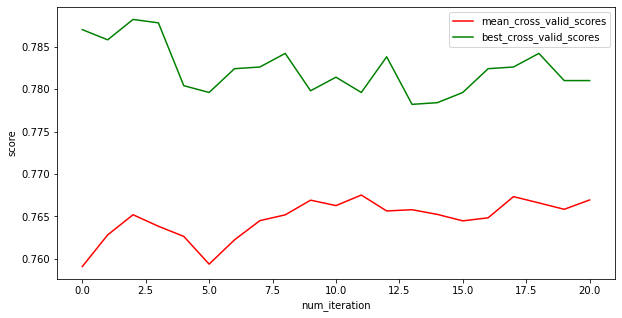

In [10]:
plt.figure(figsize = (10, 5))
plt.plot(mean_cross_valid_scores, color = "red", label = "mean_cross_valid_scores")
plt.plot(best_cross_valid_scores, color = "green", label = "best_cross_valid_scores")
plt.xlabel("num_iteration")
plt.ylabel("score")
plt.legend()
plt.plot()
plt.show()

In [38]:
header_name = np.array(pd.read_csv("./data1forEx1to4/train1_icu_data.csv", header = None))[0]
selected_features = end_population[np.argmax(end_fitness)]
print("遗传算法选取的特征为：")
for i in range(len(selected_features)):
    if(selected_features[i]):
        print(header_name[i])

遗传算法选取的特征为：
age
bmi
elective_surgery
pre_icu_los_days
arf_apache
bun_apache
creatinine_apache
gcs_verbal_apache
glucose_apache
heart_rate_apache
map_apache
sodium_apache
ventilated_apache
wbc_apache
d1_diasbp_max
d1_heartrate_min
d1_mbp_max
d1_spo2_max
d1_sysbp_max
d1_temp_max
d1_temp_min
h1_diasbp_min
h1_mbp_max
h1_mbp_min
h1_resprate_max
h1_spo2_max
h1_spo2_min
h1_sysbp_max
h1_sysbp_min
d1_calcium_max
d1_glucose_min
d1_hemaglobin_max
d1_platelets_max
d1_potassium_min
d1_sodium_max
apache_4a_icu_death_prob
aids
cirrhosis
hepatic_failure
immunosuppression
leukemia
ethnicity_African American
ethnicity_Other/Unknown
icu_type_CCU-CTICU
icu_type_CSICU
icu_type_MICU
icu_type_SICU
apache_3j_bodysystem_Cardiovascular
apache_3j_bodysystem_Gastrointestinal
apache_3j_bodysystem_Gynecological
apache_3j_bodysystem_Hematological
apache_3j_bodysystem_Metabolic
apache_3j_bodysystem_Musculoskeletal/Skin
apache_3j_bodysystem_Neurological
apache_3j_bodysystem_Respiratory
apache_2_bodysystem_Cardiovascul

In [39]:
print("进行特征提取前的训练和测试结果：")
train_and_test(folds = folds, classifier = LogisticRegression())

进行特征提取前的训练和测试结果：
|Fold     |train accuracy  |train sensi     |train speci     |valid accuracy  |valid sensi     |valid speci     |test accuracy   |test sensi      |test speci      |
|---------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|
|1        |0.796000        |0.787255        |0.805102        |0.805000        |0.813725        |0.795918        |0.791249        |0.765996        |0.816364        |
|2        |0.803500        |0.802451        |0.804592        |0.761000        |0.729412        |0.793878        |0.783956        |0.758684        |0.809091        |
|3        |0.804500        |0.809314        |0.799490        |0.770000        |0.760784        |0.779592        |0.792160        |0.786106        |0.798182        |
|4        |0.800250        |0.794118        |0.806633        |0.790000        |0.792157        |0.787755        |0.780310        |0.767824        |0.792727   

In [40]:
print("进行遗传算法特征提取后的训练和测试结果：")
selected_features = end_population[np.argmax(end_fitness)]
train1_features = train1_X[:, np.where(selected_features==1)[0]]
test1_features = test1_X[:, np.where(selected_features==1)[0]]
folds__ = K_fold_divide(train1_features, train1_label, K = 5)
train_and_test(folds = folds__, test1_X = test1_features, classifier = LogisticRegression())

进行遗传算法特征提取后的训练和测试结果：
|Fold     |train accuracy  |train sensi     |train speci     |valid accuracy  |valid sensi     |valid speci     |test accuracy   |test sensi      |test speci      |
|---------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|
|1        |0.781500        |0.776471        |0.786735        |0.803000        |0.805882        |0.800000        |0.770283        |0.755027        |0.785455        |
|2        |0.790250        |0.786275        |0.794388        |0.772000        |0.737255        |0.808163        |0.760255        |0.749543        |0.770909        |
|3        |0.784500        |0.781373        |0.787755        |0.774000        |0.766667        |0.781633        |0.767548        |0.749543        |0.785455        |
|4        |0.791000        |0.783824        |0.798469        |0.758000        |0.760784        |0.755102        |0.770283        |0.758684        |0.78181

# 3.Lasso

In [42]:
lassocv = LassoCV()
lassocv.fit(train1_X, train1_label.reshape(-1))
alpha = lassocv.alpha_
print("最优alpha = %f"%(alpha))

最优alpha = 0.001843


In [44]:
lasso = Lasso(alpha)
lasso.fit(train1_X, train1_label.reshape(-1))
print(lasso.coef_)

[ 5.83584409e-02 -0.00000000e+00 -3.56544698e-02 -6.97823784e-04
  2.56573639e-02 -5.81626766e-03  2.68430628e-03 -5.47517476e-03
  9.93602533e-03  4.54281362e-02  4.58199820e-03 -2.07045230e-02
 -2.69230117e-02 -2.53616956e-02 -2.02955078e-03  0.00000000e+00
  1.81808601e-02  2.07157981e-03  8.46952051e-03  1.18443919e-02
 -1.93726489e-02 -0.00000000e+00  7.38046049e-02  3.42296880e-02
  0.00000000e+00 -0.00000000e+00  4.80033414e-02  2.12079696e-02
 -5.95590153e-03 -1.29058018e-02  5.90526687e-03  0.00000000e+00
  0.00000000e+00 -3.06330648e-02 -7.76343868e-03 -2.96187922e-02
  1.84161004e-02 -4.35344885e-02  8.58530386e-03  0.00000000e+00
 -2.86971633e-02  4.45401825e-03 -0.00000000e+00 -2.60968637e-02
  1.03977978e-02  2.35934626e-02 -2.45770943e-03  2.65889176e-03
 -0.00000000e+00  1.85451519e-02 -1.83254663e-02 -0.00000000e+00
  1.81234730e-02 -2.78004102e-02  2.45212075e-03 -1.19032555e-03
 -1.41805132e-02 -3.38473667e-02 -1.19811273e-02  8.93544574e-03
 -4.11200271e-03  0.00000

In [50]:
header_name = np.array(pd.read_csv("./data1forEx1to4/train1_icu_data.csv", header = None))[0]
selected_features = np.where(lasso.coef_!=0)[0]
print("Lasso回归选取的特征为：")
for i in selected_features:
    print(header_name[i])

Lasso回归选取的特征为：
age
elective_surgery
height
pre_icu_los_days
weight
apache_2_diagnosis
apache_3j_diagnosis
arf_apache
bun_apache
creatinine_apache
gcs_eyes_apache
gcs_motor_apache
gcs_verbal_apache
glucose_apache
hematocrit_apache
intubated_apache
map_apache
resprate_apache
sodium_apache
ventilated_apache
wbc_apache
d1_heartrate_max
d1_heartrate_min
d1_mbp_max
d1_mbp_min
d1_resprate_max
d1_spo2_min
d1_sysbp_max
d1_sysbp_min
d1_temp_max
d1_temp_min
h1_diasbp_max
h1_heartrate_max
h1_heartrate_min
h1_mbp_min
h1_resprate_max
h1_resprate_min
h1_spo2_max
h1_spo2_min
h1_sysbp_min
h1_temp_max
d1_calcium_max
d1_calcium_min
d1_glucose_min
d1_hco3_max
d1_hco3_min
d1_hemaglobin_max
d1_platelets_max
d1_potassium_max
d1_potassium_min
apache_4a_icu_death_prob
aids
cirrhosis
diabetes_mellitus
hepatic_failure
immunosuppression
lymphoma
solid_tumor_with_metastasis
ethnicity_African American
ethnicity_Hispanic
gender_F
icu_type_CCU-CTICU
icu_type_CSICU
icu_type_CTICU
icu_type_Cardiac ICU
icu_type_Med-Surg

In [51]:
print("进行lasso回归特征提取后的训练和测试结果：")
train1_features = train1_X[:, selected_features]
test1_features = test1_X[:, selected_features]
folds___ = K_fold_divide(train1_features, train1_label, K = 5)
train_and_test(folds = folds___, test1_X = test1_features, classifier = LogisticRegression())

进行lasso回归特征提取后的训练和测试结果：
|Fold     |train accuracy  |train sensi     |train speci     |valid accuracy  |valid sensi     |valid speci     |test accuracy   |test sensi      |test speci      |
|---------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|
|1        |0.794500        |0.785784        |0.803571        |0.810000        |0.819608        |0.800000        |0.784868        |0.756856        |0.812727        |
|2        |0.802500        |0.801471        |0.803571        |0.769000        |0.731373        |0.808163        |0.782133        |0.753199        |0.810909        |
|3        |0.800500        |0.801471        |0.799490        |0.774000        |0.770588        |0.777551        |0.785779        |0.771481        |0.800000        |
|4        |0.800500        |0.793137        |0.808163        |0.791000        |0.792157        |0.789796        |0.782133        |0.755027        |0.80

# 4.Random Forest

In [67]:
train_and_test(classifier = RandomForestClassifier(criterion = "gini", n_jobs=-1))

|Fold     |train accuracy  |train sensi     |train speci     |valid accuracy  |valid sensi     |valid speci     |test accuracy   |test sensi      |test speci      |
|---------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|
|1        |1.000000        |1.000000        |1.000000        |0.818000        |0.831373        |0.804082        |0.800365        |0.815356        |0.785455        |
|2        |1.000000        |1.000000        |1.000000        |0.787000        |0.774510        |0.800000        |0.794895        |0.797075        |0.792727        |
|3        |1.000000        |1.000000        |1.000000        |0.808000        |0.825490        |0.789796        |0.799453        |0.811700        |0.787273        |
|4        |1.000000        |1.000000        |1.000000        |0.798000        |0.805882        |0.789796        |0.798541        |0.815356        |0.781818        |
|5        

In [68]:
train_and_test(classifier = RandomForestClassifier(criterion = "entropy", n_jobs=-1))

|Fold     |train accuracy  |train sensi     |train speci     |valid accuracy  |valid sensi     |valid speci     |test accuracy   |test sensi      |test speci      |
|---------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|
|1        |1.000000        |1.000000        |1.000000        |0.819000        |0.817647        |0.820408        |0.796718        |0.800731        |0.792727        |
|2        |1.000000        |1.000000        |1.000000        |0.781000        |0.764706        |0.797959        |0.793984        |0.798903        |0.789091        |
|3        |1.000000        |1.000000        |1.000000        |0.799000        |0.805882        |0.791837        |0.798541        |0.809872        |0.787273        |
|4        |1.000000        |1.000000        |1.000000        |0.801000        |0.821569        |0.779592        |0.807657        |0.819013        |0.796364        |
|5        

In [70]:
train_and_test(classifier = RandomForestClassifier(criterion = "gini", n_estimators = 10, n_jobs=-1))

|Fold     |train accuracy  |train sensi     |train speci     |valid accuracy  |valid sensi     |valid speci     |test accuracy   |test sensi      |test speci      |
|---------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|
|1        |0.989500        |0.983333        |0.995918        |0.786000        |0.735294        |0.838776        |0.761167        |0.725777        |0.796364        |
|2        |0.990750        |0.986275        |0.995408        |0.750000        |0.698039        |0.804082        |0.772106        |0.742230        |0.801818        |
|3        |0.990000        |0.987745        |0.992347        |0.776000        |0.756863        |0.795918        |0.780310        |0.753199        |0.807273        |
|4        |0.989750        |0.984804        |0.994898        |0.771000        |0.735294        |0.808163        |0.768459        |0.733090        |0.803636        |
|5        

In [71]:
train_and_test(classifier = RandomForestClassifier(criterion = "gini", max_depth = 10, n_jobs=-1))

|Fold     |train accuracy  |train sensi     |train speci     |valid accuracy  |valid sensi     |valid speci     |test accuracy   |test sensi      |test speci      |
|---------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|
|1        |0.953250        |0.937745        |0.969388        |0.825000        |0.837255        |0.812245        |0.794895        |0.800731        |0.789091        |
|2        |0.953250        |0.940686        |0.966327        |0.772000        |0.750980        |0.793878        |0.795807        |0.804388        |0.787273        |
|3        |0.954250        |0.940196        |0.968878        |0.801000        |0.811765        |0.789796        |0.803099        |0.815356        |0.790909        |
|4        |0.952750        |0.937255        |0.968878        |0.801000        |0.805882        |0.795918        |0.795807        |0.802559        |0.789091        |
|5        

In [64]:
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(train1_X, train1_label.reshape(-1))
importances = rfc.feature_importances_
print(importances)

[1.59216431e-02 1.25713544e-02 2.13118742e-03 8.96350770e-03
 1.34072195e-02 1.23604138e-02 1.58597895e-02 1.81669857e-02
 5.31911940e-04 3.30654734e-02 3.02341012e-02 2.63028149e-02
 2.35659945e-02 1.77868259e-02 1.28497301e-02 1.25419742e-02
 1.20990324e-02 1.02569444e-02 1.12608794e-02 1.14595248e-02
 1.19189431e-02 1.68045090e-02 2.30362291e-02 1.57605473e-02
 9.69112840e-03 1.42198383e-02 1.31637580e-02 1.38082894e-02
 9.05025151e-03 1.60387953e-02 1.50503596e-02 9.46155652e-03
 2.69030123e-03 1.74368477e-02 1.14740307e-02 2.96298084e-02
 1.20477607e-02 2.15456731e-02 9.64429627e-03 1.03172339e-02
 9.06539469e-03 1.04998967e-02 9.14522787e-03 1.18302572e-02
 1.25313425e-02 1.20703345e-02 4.97306946e-03 8.01984338e-03
 1.15093731e-02 1.38856894e-02 1.14937348e-02 1.02864822e-02
 9.31534761e-03 1.08990910e-02 1.27400831e-02 1.09699711e-02
 1.98383725e-02 1.17628985e-02 1.47927029e-02 9.35254840e-03
 9.93385651e-03 1.17823389e-02 1.29911520e-01 1.48407482e-05
 5.24454662e-04 1.389277

In [65]:
selected_features = np.where(importances>0.001)[0]
print("随机森林选取的特征为：")
for i in selected_features:
    print(header_name[i])

随机森林选取的特征为：
age
bmi
elective_surgery
height
pre_icu_los_days
weight
apache_2_diagnosis
apache_3j_diagnosis
bun_apache
creatinine_apache
gcs_eyes_apache
gcs_motor_apache
gcs_verbal_apache
glucose_apache
heart_rate_apache
hematocrit_apache
intubated_apache
map_apache
resprate_apache
sodium_apache
temp_apache
ventilated_apache
wbc_apache
d1_diasbp_max
d1_diasbp_min
d1_heartrate_max
d1_heartrate_min
d1_mbp_max
d1_mbp_min
d1_resprate_max
d1_resprate_min
d1_spo2_max
d1_spo2_min
d1_sysbp_max
d1_sysbp_min
d1_temp_max
d1_temp_min
h1_diasbp_max
h1_diasbp_min
h1_heartrate_max
h1_heartrate_min
h1_mbp_max
h1_mbp_min
h1_resprate_max
h1_resprate_min
h1_spo2_max
h1_spo2_min
h1_sysbp_max
h1_sysbp_min
h1_temp_max
h1_temp_min
d1_calcium_max
d1_calcium_min
d1_glucose_min
d1_hco3_max
d1_hco3_min
d1_hemaglobin_max
d1_platelets_max
d1_potassium_max
d1_potassium_min
d1_sodium_max
apache_4a_icu_death_prob
diabetes_mellitus
ethnicity_African American
ethnicity_Caucasian
gender_F
gender_M
icu_type_MICU
icu_type_

In [66]:
print("进行随机森林特征提取后的训练和测试结果：")
train1_features = train1_X[:, selected_features]
test1_features = test1_X[:, selected_features]
folds___ = K_fold_divide(train1_features, train1_label, K = 5)
train_and_test(folds = folds___, test1_X = test1_features, classifier = LogisticRegression())

进行随机森林特征提取后的训练和测试结果：
|Fold     |train accuracy  |train sensi     |train speci     |valid accuracy  |valid sensi     |valid speci     |test accuracy   |test sensi      |test speci      |
|---------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|
|1        |0.790000        |0.785784        |0.794388        |0.810000        |0.817647        |0.802041        |0.782133        |0.758684        |0.805455        |
|2        |0.799250        |0.797549        |0.801020        |0.762000        |0.725490        |0.800000        |0.780310        |0.758684        |0.801818        |
|3        |0.798750        |0.797549        |0.800000        |0.772000        |0.754902        |0.789796        |0.784868        |0.765996        |0.803636        |
|4        |0.793000        |0.792647        |0.793367        |0.780000        |0.782353        |0.777551        |0.781222        |0.760512        |0.80181